In [10]:
# training the model with corn_data_set  

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os


# -----------------------------------------------------------
# 🗂️ Paths
# -----------------------------------------------------------
DATASET_DIR = r"C:\Users\pavan\Downloads\cropDetection_cnn\corn_data"
MODEL_SAVE_PATH = r"C:\Users\pavan\Downloads\cropDetection_cnn\models\corn_cnn_v2.h5"

train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

# -----------------------------------------------------------
# 🧩 Data Preprocessing
# -----------------------------------------------------------
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

print("\nClass Indices:", train_gen.class_indices)


Found 4102 images belonging to 4 classes.
Found 178 images belonging to 4 classes.

Class Indices: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [11]:
#model training on cnn
# ============================================================
# 🏗️ CNN Model Architecture
# ============================================================

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 128)     

In [12]:
# 🧩 Callbacks (Early Stop + Best Model Save)
# ============================================================

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    # class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/5
129/129 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.6431
Epoch 1: val_accuracy improved from -inf to 0.39888, saving model to C:\Users\pavan\Downloads\cropDetection_cnn\models\corn_cnn_v2.h5
129/129 [==============================] - 138s 1s/step - loss: 0.9272 - accuracy: 0.6431 - val_loss: 1.3203 - val_accuracy: 0.3989
Epoch 2/5
104/129 [=======================>......] - ETA: 25s - loss: 0.4857 - accuracy: 0.8038

<function matplotlib.pyplot.show(close=None, block=None)>

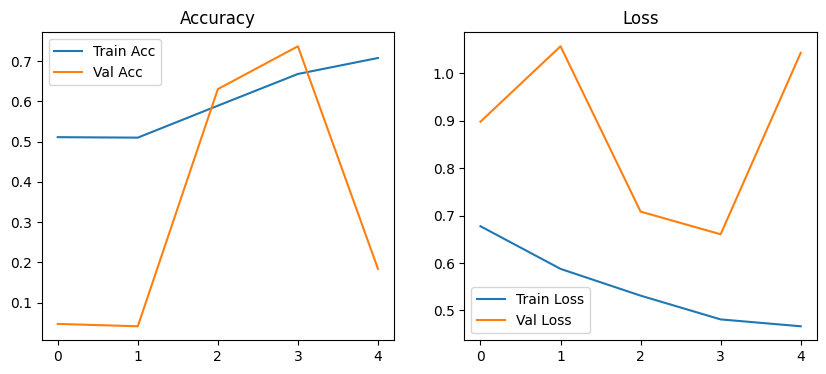

In [20]:
r# 📊 Visualize Training
# ============================================================

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show

In [6]:
# ============================================================
# Test with One Image (Fixed Label Mapping)
# ============================================================

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load trained model
test_model = load_model(MODEL_SAVE_PATH)

# ✅ Get class labels in correct order
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)

# Test Image Path
img_path = r"C:\Users\pavan\Downloads\cropDetection_cnn\Corn_Health (12).jpg"  # change if needed

# Load and preprocess
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# Predict
pred = test_model.predict(x)
pred_index = np.argmax(pred, axis=1)[0]
confidence = np.max(pred) * 100

# ✅ Correct label from index
pred_label = class_labels[pred_index]

print(f"\n🌿 Predicted Class: {pred_label}")
print(f"Confidence: {confidence:.2f}%")


Class Labels: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
1/1 [==============================] - 0s 137ms/step

🌿 Predicted Class: Common_Rust
Confidence: 76.62%


In [4]:
# ============================================================
#  Live/Video Detection using trained CNN model
# ============================================================

import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# Load your trained model
model = load_model(MODEL_SAVE_PATH)
print("\n Model loaded successfully for video detection!")

# Class labels (taken from training generator)
labels = list(train_gen.class_indices.keys())
IMG_SIZE = (128, 128)

def predict_frame(frame):
    img = cv2.resize(frame, IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    label = labels[np.argmax(preds)]
    conf = np.max(preds)
    return label, conf

def detect_from_video(source=0):
    cap = cv2.VideoCapture(source)

    if not cap.isOpened():
        print("❌ Could not open video source.")
        return

    print("🎬 Press 'q' to quit the video window.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        label, conf = predict_frame(frame_rgb)

        # Draw prediction text on frame
        cv2.putText(frame, f"{label} ({conf*100:.1f}%)", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Corn Disease Detection - Video Feed", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# ============================================================
# 🎬 MENU: Choose Live or Video Upload
# ============================================================

print("\n🎥 Video/Live Detection Options")
print("1️⃣  Detect from Live Camera")
print("2️⃣  Detect from Video File (MP4/AVI)")

choice = input("Enter your choice (1 or 2): ")

if choice == "1":
    detect_from_video(0)

elif choice == "2":
    video_path = input("Enter full path to your video file: ")
    detect_from_video(video_path)

else:
    print("❌ Invalid choice. Exiting.")



 Model loaded successfully for video detection!

🎥 Video/Live Detection Options
1️⃣  Detect from Live Camera
2️⃣  Detect from Video File (MP4/AVI)


Enter your choice (1 or 2):  1


🎬 Press 'q' to quit the video window.
1/1 [==============================] - 0s 42ms/step
